In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDFSFIX, R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

from pyha import Hardware, simulate, sims_close, Complex, Sfix
from pyha.common.float import *
# Float.use_float16 = True
# Float.use_float16 = False

from mpmath import mp 
results = {}

# FIR tests

In [2]:
class FIRFloat(Hardware):
    def __init__(self, taps):
        self.DELAY = 2

        self.TAPS = [Float(x) for x in np.array(taps).tolist()]
#         self.TAPS = np.array(taps).tolist()
        self.TAPS_ORIG = taps

        # registers
        self.acc = [Float()] * len(taps)
        self.mul = [Float()] * len(taps)
        # self.out = Float()

    def main(self, x):
        """ Transposed FIR structure """
        self.acc[0] = x * self.TAPS[-1]
        for i in range(1, len(self.acc)):
            self.mul[i] = x * self.TAPS[len(self.TAPS) - 1 - i]
            self.acc[i] = self.acc[i - 1] + self.mul[i]

        return self.acc[-1]

    def model_main(self, x):
        return signal.lfilter(self.TAPS_ORIG, [1.0], x)

In [3]:
np.random.seed(0)
taps = signal.remez(128, [0, 0.1, 0.2, 0.5], [1, 0])
# taps = signal.remez(511, [0, 0.4/2, 0.41/2, 1.0/2], [1, 0])
# taps = np.random.uniform(-1, 1, 256)
inp = np.random.uniform(-1, 1, 1024)

In [4]:
Float.radix = 32
Float.default_exponent_bits = 3
Float.default_fractional_bits = 15
Float.use_float16 = False
dut = FIRFloat(taps)
sims = simulate(dut, inp, input_types=[Float()], simulations=['MODEL', 'PYHA'])
results['Float64'] = np.array([float(x) for x in sims['MODEL']])
results['Radix32'] = np.array([float(x) for x in sims['PYHA']])

Float.radix = 16
Float.default_exponent_bits = 4
Float.default_fractional_bits = 14
Float.use_float16 = False
dut = FIRFloat(taps)
sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
results['Radix16'] = np.array([float(x) for x in sims['PYHA']])

print('Running float16')
Float.use_float16 = True
Float.radix = 16
Float.default_exponent_bits = 1
Float.default_fractional_bits = 1
dut = FIRFloat(taps)
sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
results['Float16'] = np.array([float(x) for x in sims['PYHA']])


INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1026/1026 [00:02<00:00, 430.05it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



100%|██████████| 1026/1026 [00:02<00:00, 394.84it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



Running float16
100%|██████████| 1026/1026 [00:00<00:00, 1579.75it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


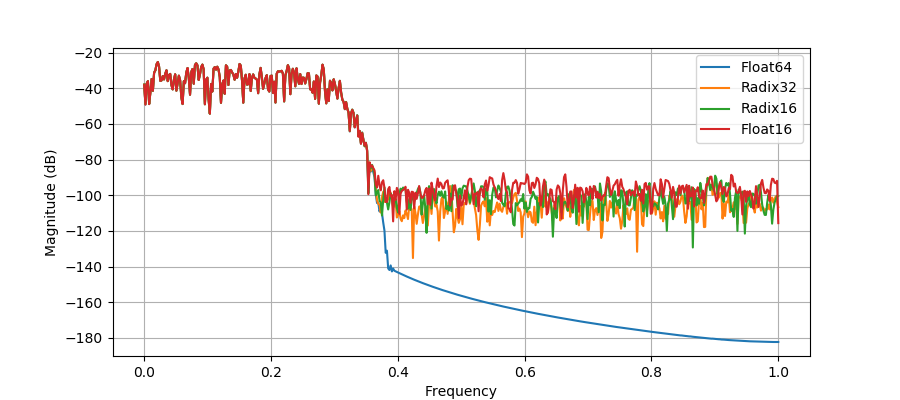

<IPython.core.display.Javascript object>


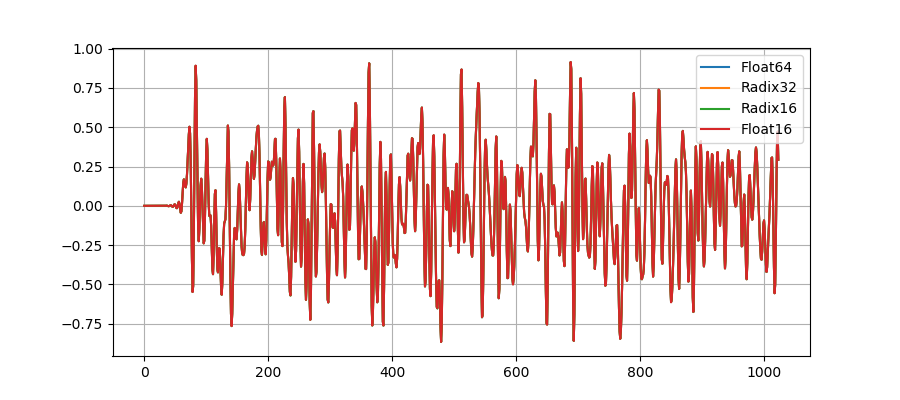

In [5]:
for key, val in results.items():
    plt.magnitude_spectrum(val, scale='dB', label=key)
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    plt.plot(val, label=key)
plt.legend()
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


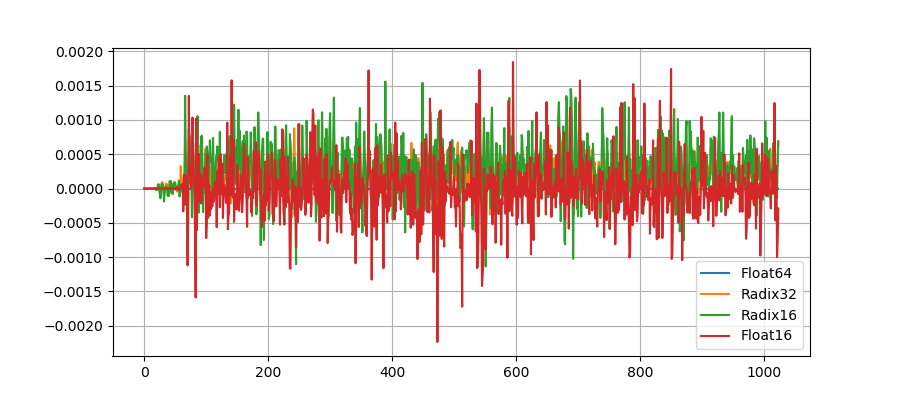

Float64 SNR: inf dB
Radix32 SNR: 60.041439478485835 dB
Radix16 SNR: 56.6119899044852 dB
Float16 SNR: 58.94898493380129 dB


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=key)
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)